# Image classifier

https://www.youtube.com/watch?v=9OHlgDjaE2I

NB: Images are 1920 x 1080, 2.9MB, 72 dpi, 32 bit

Qs:
- Does it matter what I resize my images to? Does it matter what size the images are in general?

In [8]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt

In [3]:
print(torch.version.cuda)

None


In [4]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


- Batchsize needs to match requirements of CPU, don't want to lead to memory overload.
- 

In [6]:
#Transforms
transformer_train=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(), # flips image with p=0.5 to augment data
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

transformer_test=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

train_path = 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/raw/test'
test_path = 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/raw/train'

train_loader=torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(root=train_path, transform=transformer_train),
    batch_size=1, shuffle=True
)
test_loader=torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(root=test_path, transform=transformer_test),
    batch_size=1, shuffle=True
)

Feature batch shape: torch.Size([1, 3, 150, 150])
Labels batch shape: torch.Size([1])


TypeError: Invalid shape (3, 150, 150) for image data

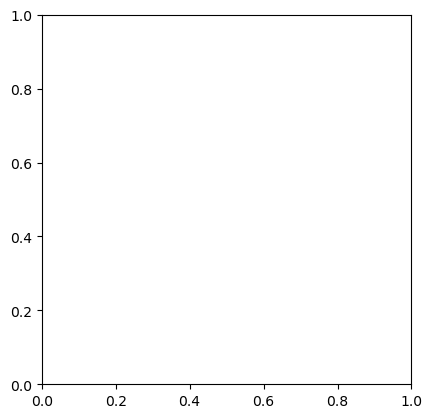

In [9]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [5]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['KnitCap', 'clear']


In [6]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=len(classes)):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        #w=150 (width)
        #f=3 (kernel size, size of filter)
        #p=1 (padding)
        #s=1 (stride)
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #((150-3+2)/1)+1 = 150
        #Shape= (256,out_channels,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12) #num_features = out_channels
        # shape not changed as not passed thru conv2d
        #Shape= (256,out_channels,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,out_channels,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size (width and height) be factor 2
        #Shape= (256,out_channels,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #((75-3+2)/1)+1 = 75
        #Shape= (256,out_channels,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,out_channels,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,out_channels,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,out_channels,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,out_channels,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
            #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output        

In [7]:
model=ConvNet(num_classes=len(classes)).to(device)

In [8]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [9]:
num_epochs=20

In [10]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
test_count=len(glob.glob(test_path+'/**/*.png'))

In [11]:
print(train_count,test_count)

81 42


In [12]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy


Epoch: 0 Train Loss: tensor(24.5493) Train Accuracy: 0.5679012345679012 Test Accuracy: 0.5714285714285714
Epoch: 1 Train Loss: tensor(31.1242) Train Accuracy: 0.5802469135802469 Test Accuracy: 0.5238095238095238
Epoch: 2 Train Loss: tensor(29.9197) Train Accuracy: 0.6419753086419753 Test Accuracy: 0.5476190476190477
Epoch: 3 Train Loss: tensor(24.5789) Train Accuracy: 0.6172839506172839 Test Accuracy: 0.42857142857142855
Epoch: 4 Train Loss: tensor(15.4697) Train Accuracy: 0.6790123456790124 Test Accuracy: 0.5238095238095238
Epoch: 5 Train Loss: tensor(10.7155) Train Accuracy: 0.7407407407407407 Test Accuracy: 0.5238095238095238
Epoch: 6 Train Loss: tensor(7.8433) Train Accuracy: 0.7530864197530864 Test Accuracy: 0.5476190476190477
Epoch: 7 Train Loss: tensor(6.3096) Train Accuracy: 0.7654320987654321 Test Accuracy: 0.6428571428571429
Epoch: 8 Train Loss: tensor(4.6659) Train Accuracy: 0.8271604938271605 Test Accuracy: 0.5952380952380952
Epoch: 9 Train Loss: tensor(4.4594) Train Accura